In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datetime
from os import listdir
import os 
from planet_common.raster import plimage
from planet_common.calibration import mask as imagemask, ground_radiometric_calibration
from planet_common.client import storage, urls
import subprocess
urls.set_urls('pl')
from osgeo import gdal, gdal_array
import matplotlib.pyplot as plt
import math
import csv


In [3]:
def scene_search_by_geojson_filter(bucket,sat,poly):
    scene_file=[];
    scene_name=[];
    scene_filter = storage.SceneFilter(satellite=sat,rpoly=poly)
    for scene in storage.BucketIterator(bucket,scene_filter=scene_filter):
        scene_file.append(storage.get_scene_file(None, bucket, scene['name']))
        scene_name.append(scene['name'])
    return scene_file,scene_name
    
def read_image(image_path):
    pl_image = plimage.load(image_path)
    #alphas = imagemask.generate_alpha_masks(pl_image, camera_type)
    if pl_image.alpha is None:
            pl_image.create_alpha()
    '''pl_rgb = np.clip((np.dstack(pl_image.bands) / 2**2), 0, 255).astype(np.uint8) 
    pl_rgb[pl_image.alpha == 0, :] = 0
    plt.imshow(pl_rgb)'''
    '''for b in pl_image.bands:
        b[pl_image.alpha == 0]=0'''
        
    #pl_image.bands[0][pl_image.alpha == 0] = 0
    #pl_image.save('test.tif')
    return (pl_image)


In [4]:
def find_Landsat_image(Landsat_bucket, pl_img):
    images=np.array(listdir(Landsat_bucket))
    numofscenes=len(images) 
    yyyy=str(pl_img[0:4])
    mm= str(pl_img[4:6])
    dd=str(pl_img[6:8]) 
    fmt = '%Y.%m.%d'
    date=yyyy+'.'+mm+'.'+dd
    dt = datetime.datetime.strptime(date, fmt)
    tt = dt.timetuple()
    pl_doy=tt.tm_yday
    for z in range(0, numofscenes):
        date=images[z]
        if (date[0:2]=='LC'):
            l8_yyyy=date[9:13]
            l8_doy=date[13:16]
            if(l8_yyyy==yyyy):
                if(abs(int(pl_doy)-int(l8_doy))<9):
                    landsat_image=images[z]
    
    return landsat_image
    

In [5]:
def calculate_band_averaged_dns(pl_image):
    alpha_mask = pl_image.alpha == 0
    
    band_averaged_dns = [np.ma.masked_array(b, mask=alpha_mask).mean()
                         for b in pl_image.bands]

    return np.array(band_averaged_dns)

In [6]:
def extent_to_shp(input_filename, shp_filename):
    if os.path.isfile(shp_filename):
        os.unlink(shp_filename)
    opts = ['-t_srs', 'EPSG:4326']
    cmds = ['gdaltindex'] + opts + [shp_filename, input_filename]
    subprocess.check_call(cmds)

def image_stack(input_filenames, output_filenames, image):
    temp_shapefile = "tmp.shp"
    extent_to_shp(image, temp_shapefile)

    gdal_ds = gdal.Open(image)
    if gdal_ds is None:
        raise Exception('Unable to open file "%s" with gdal.Open()' % (
            image))
    
    for input_filename, output_filename in zip(input_filenames, output_filenames):
        opts = ['-q', '-overwrite']
        #, '-dstnodata', str(nodata)]
        opts += ['-crop_to_cutline', '-cutline', temp_shapefile]
        opts += ['-ts', str(gdal_ds.RasterXSize), str(gdal_ds.RasterYSize)]
        cmds = ['gdalwarp'] + opts + [input_filename, output_filename]
        subprocess.check_call(cmds)
    os.remove("tmp.shp")

In [7]:
def get_metadata(MTL_filename):
    mtl = open(MTL_filename, 'r')
    keyvalues = [l.strip().split(' = ')
                    for l in mtl.read().split('\n')
             if l != '' and l != 'END']
    metadata = dict((k,v) for (k,v) in keyvalues
                    if k.lower() != 'group'
                       and k.lower() != 'end_group')
    return metadata

In [8]:
def get_fullpath(Landsat_bucket,landsat_imagename,scene_path):
    l8_rgb_orig=[Landsat_bucket+'/'+
                landsat_imagename +'/' 
                +landsat_imagename+
                '_b{}.tif' .format(b) for b in (4, 3, 2)]
                
    l8_rgb_filenames = ['{}.crop.tif'.format(b) for b in l8_rgb_orig]
    
    l8_meta_filename= Landsat_bucket+ '/' + landsat_imagename + '/'  + landsat_imagename + '_MTL.TXT'
    image_stack(l8_rgb_orig, l8_rgb_filenames, scene_path)
    return l8_rgb_filenames,l8_meta_filename
            


In [9]:
def get_earth_sun_distance(doy):
    with open('tables/sundistance.csv', 'rb') as csvfile:
        data1 = list(csv.reader(csvfile, delimiter=','))
    sundistance = np.array([float(row[0]) for row in data1])
    return sundistance[doy]

In [10]:
def get_average_radiance(l8_rgb_filenames,l8_meta,alphas):
    bnad_DN=[]
    for fn in l8_rgb_filenames:
            landsat_image = read_image(fn)
            landsat_image=create_alpha(landsat_image,alphas)
            bnad_DN.append(calculate_band_averaged_dns(landsat_image))
    DN_mean = np.array(map(float,[b for b in bnad_DN]))
    mtl = get_metadata(l8_meta)
    doy = int(mtl['LANDSAT_SCENE_ID'][14:17])
    elevation_angle=math.radians(float(mtl['SUN_ELEVATION']))
    RADIANCE_MULT_BAND=map(float,np.array([mtl['RADIANCE_MULT_BAND_'+'%01d' % k] for k in (4, 3, 2)]))
    RADIANCE_ADD_BAND=map(float,np.array([mtl['RADIANCE_ADD_BAND_'+'%01d' % k]for k in (4, 3, 2)]))
    Radiance_average=(DN_mean*RADIANCE_MULT_BAND+RADIANCE_ADD_BAND)*pow(get_earth_sun_distance(doy),2)/math.sin(elevation_angle)
    return Radiance_average

In [11]:
def create_alpha(pl_image,alphas):
    original_alpha = pl_image.alpha
    tap = 0
    for tap, alpha in enumerate(alphas):
        pl_image.alpha = np.minimum(original_alpha, alpha)
    return pl_image


def get_PL_avg_DN(sat,scene_path):
    rsr_file, sensor_camera = ground_radiometric_calibration.download_pl_rsr(sat)
    pl_image=read_image(scene_path)
    alphas = imagemask.generate_alpha_masks(pl_image, sensor_camera)
    pl_image = create_alpha(pl_image,alphas)
    average_PL_DN=(calculate_band_averaged_dns(pl_image))
    return average_PL_DN,alphas

In [12]:
def get_scene_image(bucket,sat,poly,Landsat_bucket):
    average_PL_DN=[]
    average_radiance=[]
    scene_file,scene_name=scene_search_by_geojson_filter(bucket,sat,poly)
    for scene_path,scene in zip(scene_file,scene_name):
        average_PL,alphas= get_PL_avg_DN(sat,scene_path)
        average_PL_DN.append(average_PL)
        landsat_im_name=find_Landsat_image(Landsat_bucket, scene)
        l8_rgb,l8_meta=get_fullpath(Landsat_bucket,landsat_im_name,scene_path)
        average_radiance.append(get_average_radiance(l8_rgb,l8_meta,alphas))
        [os.remove(b) for b in l8_rgb]   
    return average_PL_DN,average_radiance

In [13]:
def get_sbaf():
    sbaf_red,sbaf_green,sbaf_blue=[],[],[]
    %run 'bander.ipynb'
    for s in sbaf:
        sbaf_red.append(s[0])
        sbaf_green.append(s[1])
        sbaf_blue.append(s[2])
    sbaf_red=np.array(sbaf_red).mean()
    sbaf_green=np.array(sbaf_green).mean()
    sbaf_blue=np.array(sbaf_blue).mean()
    sbaf_final=[sbaf_red,sbaf_green,sbaf_blue]
    return sbaf_final
'''def get_SBAF():
    sbaf=[]
    with open('tables/hyperion_libya4.csv', 'rb') as csvfile:
        data = list(csv.reader(csvfile, delimiter=','))
    wavelength= np.array([float(row[0]) for row in data])
    for i in range(1:76):
        value= np.array([float(row[i]) for row in data])
        label,bands=bander(wavelength,value)
        sbaf.append(bands)
    return sbaf'''
        
    
def get_regression(X,Y):
    import scikits.statsmodels.api as sm
    results = sm.OLS(Y,sm.add_constant(X)).fit()
    #print results.summary()
    plt.scatter(X,Y)
    plt.plot(X, X*results.params[0] + results.params[1])
    plt.xlabel('Radiance(SBAF corrected)')
    plt.ylabel('PL_DN')
    plt.title('$DN=%3.7s*Radiance+%3.7s$'%(results.params[0], results.params[1]), fontsize=20)
    plt.show()
    
    
    
def get_plot(average_PL_DN,average_Landsat_DN,sbaf):
    red_pl,red_ld=[],[]
    green_pl,green_ld=[],[]
    blue_pl,blue_ld=[],[] 
    corrected_radiance=[sbaf*avragedn for avragedn in average_Landsat_DN]
    for rad,dn in zip(corrected_radiance,average_PL_DN):
        red_pl.append(dn[0])
        green_pl.append(dn[1])
        blue_pl.append(dn[2])
        red_ld.append(rad[0])
        green_ld.append(rad[1])
        blue_ld.append(rad[2])
    get_regression(np.array(red_ld),np.array(red_pl))
    get_regression(np.array(green_ld),np.array(green_pl))
    get_regression(np.array(blue_ld),np.array(blue_pl))


In [ ]:
Landsat_bucket='/opt/research-studies/landsat/cross_calibration'
average_PL_DN,average_Landsat_DN=get_scene_image('flock1_rectified','090c','polygon.geojson',Landsat_bucket)


In [ ]:
sbaf_averaged =get_sbaf()
get_plot(average_PL_DN,average_Landsat_DN,sbaf_averaged)

In [21]:
sbaf_averaged

[0.98051020805916977, 0.93281669906801268, 0.97496640414541413]

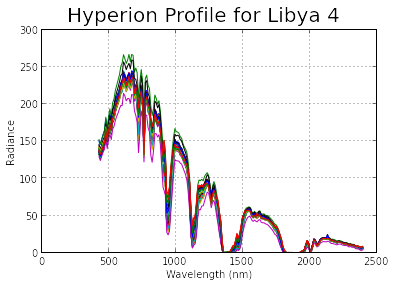

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hold(True)
with open('tables/hyperion_libya4.csv', 'rb') as csvfile:
    data = list(csv.reader(csvfile, delimiter=','))
wavelength= np.array([float(row[0]) for row in data])
for i in range(1,74):
    value= np.array([float(row[i]) for row in data])
    ax.plot(wavelength, value)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Radiance')
    ax.grid(True)
fig.suptitle('Hyperion Profile for Libya 4',fontsize=20)
plt.show()
        #label,bands=bander(wavelength,value)
        #sbaf.append(bands)
    #return sbaf